# Proyecto Capstone - La Batalla de los vecindarios. Ciencia de Datos  IBM -  Coursera

#### Comomenzamos importando las librerias necesarias para desarrollar el proyecto

In [1]:
import requests # librería para manejar las solicitudes
import pandas as pd # librería para análisis de datos
import numpy as np # librería para manejar datos vectorizados
import random # librería para generar números aleatorios

!pip install geopy
from geopy.geocoders import Nominatim # módulo para convertir una dirección en valores de latitud y longitud 

# librerías para mostrar imágenes 
from IPython.display import Image 
from IPython.core.display import HTML 
    
# librería para convertir un archivo json en un dataframe pandas
from pandas.io.json import json_normalize


! pip install folium==0.5.0
import folium # librería para graficar 

print('Folium installed')
print('Libraries imported.')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 20.7 MB/s eta 0:00:00
Folium installed
Libraries imported.


#### Para comenzar, vamos a ubicar los sectores o zonas en los que se divide la ciudad de Montevideo, los cuales son llamados barrios.

Para ello, vamos a utilizar una tabla obtenida de la siguiente fuente: https://es.wikipedia.org/wiki/Anexo:Barrios_de_Montevideo  

In [2]:
df_mv_barrios = pd.read_html('https://es.wikipedia.org/wiki/Anexo:Barrios_de_Montevideo')

Averiguamos cuantas tablas hemos extraido de la pagina de wikipedia y luego seleccionamos la que necesitamos. Dicho procedimiento se realiza mediante el metodo explicado en esta fuente: https://gsutter.medium.com/c%C3%B3mo-leer-tablas-html-con-pandas-ef1c59ffa81a

In [3]:
print(f'Número total de tablas: {len(df_mv_barrios)}')
for i in range(len(df_mv_barrios)):
  print(df_mv_barrios[i].head())

Número total de tablas: 7
                                       Ciudad/Pueblo Población[2]​
0                                         Montevideo     1.269.552
1                                      Pajas Blancas         1.976
2                                   Santiago Vázquez         1.482
3                                            Abayubá           924
4  Montevideo rural(Melilla, Bañados de Carrasco,...        52.034
    0                                                  1
0 NaN  Este artículo o sección tiene referencias, per...
    0                                                  1
0 NaN  Este artículo o sección necesita referencias q...
           Barrio  Imagen                           Límite con otros barrios  \
0    Ciudad Vieja     NaN                     Centro y Barrio Sur (al este).   
1      Barrio Sur     NaN  Ciudad Vieja (al oeste), Centro (al norte) y P...   
2         Palermo     NaN  Cordón y Centro (al norte), Parque Rodó (al es...   
3  Punta Carretas     Na

Elegimos la tabla que tiene los datos de municipios

In [4]:
df_mv_barrios = df_mv_barrios[6]
df_mv_barrios.head()

,Ref,«Los 62 Barrios»,CCZ,* Municipios
0,1,Ciudad Vieja,1,B
1,2,Centro,1,B
2,3,Barrio Sur,1,B
3,4,Cordón,2,B
4,5,Palermo,2,B


Eliminamos la columna CCZ y Ref, tambien cambiamos los nombres de las columnas que necesitamos.

In [5]:
df_mv_barrios.drop(['Ref', 'CCZ'], axis = 1, inplace = True)
df_mv_barrios.rename(columns ={'«Los 62 Barrios»': 'Barrios', '* Municipios': 'Municipios'}, inplace = True)
df_mv_barrios

,Barrios,Municipios
0,Ciudad Vieja,B
1,Centro,B
2,Barrio Sur,B
3,Cordón,B
4,Palermo,B
...,...,...
57,"Colón Sureste, Abayubá",G
58,Colón Centro y Noroeste,G
59,"Lezica, Melilla",A y G
60,"Villa García, Manga Rural",F


#### El proximo paso es ubicar las coordenadas geograficas de cada barrio (longitud, latitud)

Para ello creamos dos diccionarios vacios (tambien pudieran usarse listas) a los cuales se les ira añadiendo elementos a traves de un ciclo for, el cual recorre cada elemento en la columna llamada barrios del dataframe df_mv_barrios y ubica la geocodifiación de cada direccion mediante la librería geocoder de Python. De no ser geoubicada la direccion, se le asignara un valor de NONE en los diccionarios

In [6]:
longitud={}
latitud={}
for i in df_mv_barrios['Barrios']:
    geolocator = Nominatim(user_agent="to_explorer")
    address = f'{i}, Montevideo, Uruguay'
    location = geolocator.geocode(address)
    if location is not None:
        latitude= location.latitude
        longitude = location.longitude
        latitud[i] = latitude
        longitud[i] = longitude    
    else:
        latitude = longitude = None
        latitud[i] = latitude
        longitud[i] = longitude

Transformamos los diccionarios con los datos de longitud y latitud de cada barrio en dos dataframe, que luego fusionamos en uno solo llamado df_mv_coord

In [7]:
df_1= pd.DataFrame([[key, longitud[key]] for key in longitud.keys()], columns=['Barrios', 'Longitud'])
df_2= pd.DataFrame([[key, latitud[key]] for key in latitud.keys()], columns=['Barrios', 'Latitud'])
df_mv_coord=pd.merge(df_1 , df_2, on='Barrios')
df_mv_coord

,Barrios,Longitud,Latitud
0,Ciudad Vieja,-56.205979,-34.906351
1,Centro,-56.189656,-34.906067
2,Barrio Sur,-56.194784,-34.911202
3,Cordón,-56.180125,-34.900827
4,Palermo,-56.180698,-34.911288
...,...,...,...
57,"Colón Sureste, Abayubá",NaN,NaN
58,Colón Centro y Noroeste,NaN,NaN
59,"Lezica, Melilla",NaN,NaN
60,"Villa García, Manga Rural",NaN,NaN


Eliminamos las filas con valores nulos del dataframe

In [8]:
df_mv_coord= df_mv_coord.dropna()
df_mv_coord.shape

(47, 3)

Reseteamos el indice del dataframe

In [9]:
df_mv_coord.reset_index(drop= True)

,Barrios,Longitud,Latitud
0,Ciudad Vieja,-56.205979,-34.906351
1,Centro,-56.189656,-34.906067
2,Barrio Sur,-56.194784,-34.911202
3,Cordón,-56.180125,-34.900827
4,Palermo,-56.180698,-34.911288
5,Parque Rodó,-56.169778,-34.910082
6,Punta Carretas,-56.160065,-34.920202
7,Pocitos,-56.150593,-34.911123
8,Buceo,-56.128658,-34.897800
9,"Parque Batlle, Villa Dolores",-56.149456,-34.896342


Ubicamos las coordenadas de la ciudad de Montevideo

In [10]:
address = 'Montevideo, Uruguay'
geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude_mv= location.latitude
longitude_mv= location.longitude
# montevideo_coord = pd.Series({'Latitud': latitude, 'Longitud': longitude})
# print('Latitud Montevideo-Ciudad:',montevideo_coord[0])
# print('Longitud Montevideo-Ciudad:',montevideo_coord[1])
print('Las coordenadas geograficas de Montevideo son {}, {}.'.format(latitude_mv, longitude_mv))

Las coordenadas geograficas de Montevideo son -34.9058916, -56.1913095.


#### El pròximo paso es obtener la cantidad de personas que habitan en cada barrio

Para esto, ubicamos los datos del ultimo censo de poblacion realizado por las autoridades responsables. Luego de indagar en la web, obtenemos el conjunto de datos publicos del ultimo censo realizado por el Instituto Nacional de Estadísticas del Uruguay. Fuente: https://www.ine.gub.uy/c/document_library/get_file?uuid=4718ab8a-c64e-439c-ba8e-7d56371b6c89&groupId=10181

In [11]:
df_mv_poblacion = pd.read_excel('https://www.ine.gub.uy/c/document_library/get_file?uuid=4718ab8a-c64e-439c-ba8e-7d56371b6c89&groupId=10181')
df_mv_poblacion.head()

,"Población por sexo, según barrio. Montevideo",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN,NaN
1,NaN,Código,NaN,Sexo,NaN
2,Barrio,de barrio,Total,Hombre,Mujer
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


Eliminamos las columnas que no necesitamos

In [12]:
df_mv_poblacion.drop(['Unnamed: 1'], axis = 1, inplace=True)
df_mv_poblacion

,"Población por sexo, según barrio. Montevideo",Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,NaN,NaN,NaN
1,NaN,NaN,Sexo,NaN
2,Barrio,Total,Hombre,Mujer
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
69,NaN,NaN,NaN,NaN
70,NaN,NaN,NaN,NaN
71,Fuente: Instituto Nacional de Estadística (INE...,NaN,NaN,NaN
72,Nota: El cuadro no incluye las personas en sit...,NaN,NaN,NaN


Eliminamos las filas que no necesitamos 

In [13]:
df_mv_poblacion.drop([0,1,2,3,4,5,6, 69,70,71,72,73], axis = 0, inplace=True)
df_mv_poblacion

,"Población por sexo, según barrio. Montevideo",Unnamed: 2,Unnamed: 3,Unnamed: 4
7,Ciudad Vieja,12555,5853,6702
8,Centro,22120,9562,12558
9,Barrio Sur,12639,5794,6845
10,Cordón,42456,18517,23939
11,Palermo,12992,5966,7026
...,...,...,...,...
64,"Colón Sureste, Abayubá",13429,6392,7037
65,Colón Centro y Noroeste,28849,13553,15296
66,"Lezica, Melilla",16030,7856,8174
67,"Villa García, Manga Rural",29502,14491,15011


Cambiamos el nombre de las columnas

In [14]:
df_mv_poblacion.rename(columns= {'Población por sexo, según barrio. Montevideo': 'Barrios', 'Unnamed: 2':'Poblacion Total', 'Unnamed: 3':'Poblacion Hombre', 'Unnamed: 4':'Poblacion Mujer'}, inplace = True)
df_mv_poblacion

,Barrios,Poblacion Total,Poblacion Hombre,Poblacion Mujer
7,Ciudad Vieja,12555,5853,6702
8,Centro,22120,9562,12558
9,Barrio Sur,12639,5794,6845
10,Cordón,42456,18517,23939
11,Palermo,12992,5966,7026
...,...,...,...,...
64,"Colón Sureste, Abayubá",13429,6392,7037
65,Colón Centro y Noroeste,28849,13553,15296
66,"Lezica, Melilla",16030,7856,8174
67,"Villa García, Manga Rural",29502,14491,15011


Vemos que el tamaño de los dataFrame son iguales en cantidad de filas (df_mv_poblacion y df_mv_barrios). Ahora fusionaremos ambos dataFrames de acuerdo al barrio para consolidar la informacion en un solo DataFrame

In [15]:
df_mv=pd.merge(df_mv_poblacion , df_mv_barrios, on='Barrios')
df_mv

,Barrios,Poblacion Total,Poblacion Hombre,Poblacion Mujer,Municipios
0,Ciudad Vieja,12555,5853,6702,B
1,Centro,22120,9562,12558,B
2,Barrio Sur,12639,5794,6845,B
3,Cordón,42456,18517,23939,B
4,Palermo,12992,5966,7026,B
5,Parque Rodó,12944,5924,7020,B
6,Punta Carretas,24181,10749,13432,B y CH
7,Pocitos,67992,29393,38599,CH
8,Buceo,36998,16649,20349,CH y E
9,"Parque Batlle, Villa Dolores",31153,13931,17222,CH


Creamos un dataframe que agrupe la poblacion por municipios y que este ordenado descendentemente

In [16]:
df_mv_muni=df_mv.groupby('Municipios', as_index= True, sort = True).sum()
df_mv_muni.sort_values('Poblacion Total', ascending=False, inplace = True)
df_mv_muni

,Barrios,Poblacion Total,Poblacion Hombre,Poblacion Mujer
Municipios,,,,
F,"Bañados de CarrascoMaroñas, Parque GuaraníFlor...",133776,64565,69211
G,"Paso de las DuranasPeñarol, LavallejaSayagoCon...",123867,58281,65586
B,Ciudad ViejaCentroBarrio SurCordónPalermoParqu...,115706,51616,64090
CH,"PocitosParque Batlle, Villa Dolores",99145,43324,55821
E,MalvínMalvín NortePunta GordaCarrascoCarrasco ...,91104,41916,49188
A,"Casabó, Pajas BlancasLa Paloma, TomkinsonLa Teja",88581,42857,45724
C,ReductoAtahualpaJacinto VeraLa FiguritaBrazo O...,59555,26791,32764
D,"CasavalleManga, Toledo Chico",59390,29273,30117
CH y E,BuceoLa Blanqueada,46598,20842,25756


Colocamos los barrios como indice en el df_mv y lo ordenamos en forma descendente de acuerdo a la Poblacion Total

In [17]:
df_mv.set_index('Barrios', inplace=True)
df_mv.sort_values('Poblacion Total', ascending=False, inplace = True)

#### Ahora, debemos localizar los datos de los ingresos percibidos por las personas en la ciudad de Montevideo y agruparlos de acuerdio a los barrios de la ciudad.

Utilizaremos la siguiente fuente para extraer dicha informacion:https://www.ine.gub.uy/c/document_library/get_file?uuid=75b6cb00-387e-40ee-a694-eb64314e81db&groupId=10181

In [18]:
df_mv_eco = pd.read_csv(r'H_2017_Terceros_1.csv')
df_mv_eco.head()

,"NUMERO,C,10","ANIO,C,4","MES,N,3,0","DPTO,N,3,0","NOMDPTO,C,15","SECC,C,2","SEGM,C,3","LOC_AGR_13,C,5","NOMLOC13,C,120","CCZ,N,2,0",...,"HT11,N,12,2","HT13,N,8,0","HT14,N,20,2","HT19,N,4,0","YHOG,N,9,0","YSVL,N,9,0","LP_06,N,8,0","LI_06,N,8,2","POBRE06,N,8,2","INDIG06,N,8,2"
0,2017000001,2017,1,1,MONTEVIDEO,17.0,6.0,1010,Montevideo,11,...,"46658,00",6000,"0,00",2,1779,40658,21015,"2979,00","0,00","0,00"
1,2017000002,2017,6,3,CANELONES,NaN,NaN,3023,"Canelones y otras (Paso Espinosa, Paso Palomeque)",0,...,"65622,00",13000,"0,00",2,1836,52622,14762,"2802,00","0,00","0,00"
2,2017000003,2017,2,1,MONTEVIDEO,24.0,108.0,1010,Montevideo,5,...,"160632,00",30000,"0,00",3,1816,130632,30817,"2981,00","0,00","0,00"
3,2017000004,2017,3,1,MONTEVIDEO,17.0,5.0,1010,Montevideo,11,...,"54159,00",8000,"0,00",5,14749,46159,48094,"2987,00","0,00","0,00"
4,2017000006,2017,5,3,CANELONES,NaN,NaN,30020,Área metropolitana de Montevideo,0,...,"83758,00",0,"5000,00",2,1836,83758,14754,"2804,00","0,00","0,00"


Seleccionamos las columnas que nos sirven para nuestro analisis y les cambiamos el nombre

In [19]:
df_mv_eco = df_mv_eco[['NOMDPTO,C,15','NOMLOC13,C,120','NOMBARRIO,C,25','ESTRED13,N,4,0','YSVL,N,9,0']]
df_mv_eco.rename(columns = {'NOMDPTO,C,15':'Departamento','NOMLOC13,C,120':'Localidad','NOMBARRIO,C,25':'Barrios','ESTRED13,N,4,0':'Estrato-SocioEconómico','YSVL,N,9,0':'Ingreso Total del Hogar'}, inplace=True)

In [20]:
df_mv_eco

,Departamento,Localidad,Barrios,Estrato-SocioEconómico,Ingreso Total del Hogar
0,MONTEVIDEO,Montevideo,Casavalle,1,40658
1,CANELONES,"Canelones y otras (Paso Espinosa, Paso Palomeque)",NaN,8,52622
2,MONTEVIDEO,Montevideo,Pocitos,5,130632
3,MONTEVIDEO,Montevideo,Manga,1,46159
4,CANELONES,Área metropolitana de Montevideo,NaN,6,83758
...,...,...,...,...,...
45355,COLONIA,Agrupación localidades entre 5.000 y 20.000 ha...,NaN,10,20956
45356,COLONIA,Agrupación localidades entre 5.000 y 20.000 ha...,NaN,10,11956
45357,MALDONADO,Agrupación localidades menores a 5.000 habitan...,NaN,8,51452
45358,SALTO,Agrupación localidades menores a 5.000 habitan...,NaN,9,20037


Ahora eliminamos todos los departamentos que no correspondan a Montevideo

In [21]:
df_mv_eco = df_mv_eco[df_mv_eco['Departamento'] == 'MONTEVIDEO']
df_mv_eco

,Departamento,Localidad,Barrios,Estrato-SocioEconómico,Ingreso Total del Hogar
0,MONTEVIDEO,Montevideo,Casavalle,1,40658
2,MONTEVIDEO,Montevideo,Pocitos,5,130632
3,MONTEVIDEO,Montevideo,Manga,1,46159
6,MONTEVIDEO,Montevideo,Cerrito,3,101439
8,MONTEVIDEO,Montevideo,Manga,2,21220
...,...,...,...,...,...
45348,MONTEVIDEO,Montevideo,Parque Rodo,4,133433
45349,MONTEVIDEO,Montevideo,"Pta. Rieles, Bella Italia",2,20566
45350,MONTEVIDEO,Montevideo,Malvin,5,37000
45351,MONTEVIDEO,Montevideo,Barrio Sur,4,23958


Eliminamos la columna de  Departamento y Localidad y nos quedamos con las columnas de los barrios y datos socioeconomicos

In [22]:
df_mv_eco.drop(['Departamento', 'Localidad'], axis = 1, inplace=True)
df_mv_eco

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Barrios,Estrato-SocioEconómico,Ingreso Total del Hogar
0,Casavalle,1,40658
2,Pocitos,5,130632
3,Manga,1,46159
6,Cerrito,3,101439
8,Manga,2,21220
...,...,...,...
45348,Parque Rodo,4,133433
45349,"Pta. Rieles, Bella Italia",2,20566
45350,Malvin,5,37000
45351,Barrio Sur,4,23958


In [23]:
df_mv_eco.reset_index(drop=True)

,Barrios,Estrato-SocioEconómico,Ingreso Total del Hogar
0,Casavalle,1,40658
1,Pocitos,5,130632
2,Manga,1,46159
3,Cerrito,3,101439
4,Manga,2,21220
...,...,...,...
17810,Parque Rodo,4,133433
17811,"Pta. Rieles, Bella Italia",2,20566
17812,Malvin,5,37000
17813,Barrio Sur,4,23958


De acuerdo a la fuente de donde se extrajo la informacion de los ingresos economicos, tenemos los siguientes niveles o extratos SocioEconómico:
1- Montevideo - Nivel económico bajo, 
2- Montevideo - Nivel económico medio - bajo, 
3- Montevideo - Nivel económico medio, 
4- Montevideo - Nivel económico medio - alto, 
5- Montevideo - Nivel económico alto

Agrupamos las filas por barrio y calculamos el promedio de los Ingresos por hogar

In [24]:
df_mv_eco = df_mv_eco.groupby('Barrios', as_index = False, sort = True).mean()
df_mv_eco.sort_values('Estrato-SocioEconómico', ascending=False, inplace = True)
df_mv_eco.reset_index(drop = True)
df_mv_eco

,Barrios,Estrato-SocioEconómico,Ingreso Total del Hogar
9,Carrasco,5.000000,203711.991968
52,Punta Carretas,5.000000,123903.657895
53,Punta Gorda,4.897260,134554.921233
48,Pocitos,4.729483,106157.284195
10,Carrasco Norte,4.561404,143188.029240
...,...,...,...
60,"Villa Garcia, Manga Rur.",1.337037,42653.870370
11,"Casabo, Pajas Blancas",1.318182,43877.379870
51,"Pta. Rieles, Bella Italia",1.300885,41534.845133
38,"Manga, Toledo Chico",1.051020,45790.755102


Creamos un nuevo daframe para agrupar el nivel socioeconomico por municipio

In [25]:
# Fusion de los Dataframes
df_mv_eco_muni=pd.merge(df_mv_eco , df_mv_barrios, on='Barrios')
# Agrupacion por municipios y ordenacion descendente
df_mv_eco_muni=df_mv_eco_muni.groupby('Municipios', as_index= True, sort = True).mean()
df_mv_eco_muni.sort_values('Estrato-SocioEconómico', ascending=False, inplace = True)
df_mv_eco_muni

,Estrato-SocioEconómico,Ingreso Total del Hogar
Municipios,,
E,4.819555,160484.980814
CH,4.729483,106157.284195
B y CH,4.543561,100786.281599
CH y E,3.926684,94242.084014
A y C,3.883621,89933.991379
B,3.521299,67917.988983
C,3.426126,69255.992486
C y D,3.357143,64123.058036
B y C,3.314775,66263.580269


Colocamos los barrios como indice del Dataframe df_mv_eco

In [26]:
df_mv_eco.set_index('Barrios', inplace = True)
df_mv_eco

,Estrato-SocioEconómico,Ingreso Total del Hogar
Barrios,,
Carrasco,5.000000,203711.991968
Punta Carretas,5.000000,123903.657895
Punta Gorda,4.897260,134554.921233
Pocitos,4.729483,106157.284195
Carrasco Norte,4.561404,143188.029240
...,...,...
"Villa Garcia, Manga Rur.",1.337037,42653.870370
"Casabo, Pajas Blancas",1.318182,43877.379870
"Pta. Rieles, Bella Italia",1.300885,41534.845133


#### Ahora en base a la informacion que hemos recabado, realizaremos algunas visualizaciones para determinar cuales son las mejores zonas en donde se podria instalar una tienda fisica

Graficamos el mapa de Montevideo y luego añadimos los marcadores de los vecindarios

In [27]:
# crear un mapa de Nueva York utilizando los valores de latitud y longitud
mapa_mv = folium.Map(location=[latitude_mv,longitude_mv], zoom_start = 12)

# añadir marcadores al mapa
for lat,lng, municipio, barrio, poblacion in zip(df_mv_coord['Latitud'],df_mv_coord['Longitud'],df_mv_barrios['Municipios'],df_mv_coord['Barrios'],df_mv_poblacion['Poblacion Total']):
    label = '{}, {}'.format(municipio, barrio)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(mapa_mv)  
    
mapa_mv

Hacemos un diagrama de barras de la Poblacion total en por cada barrio

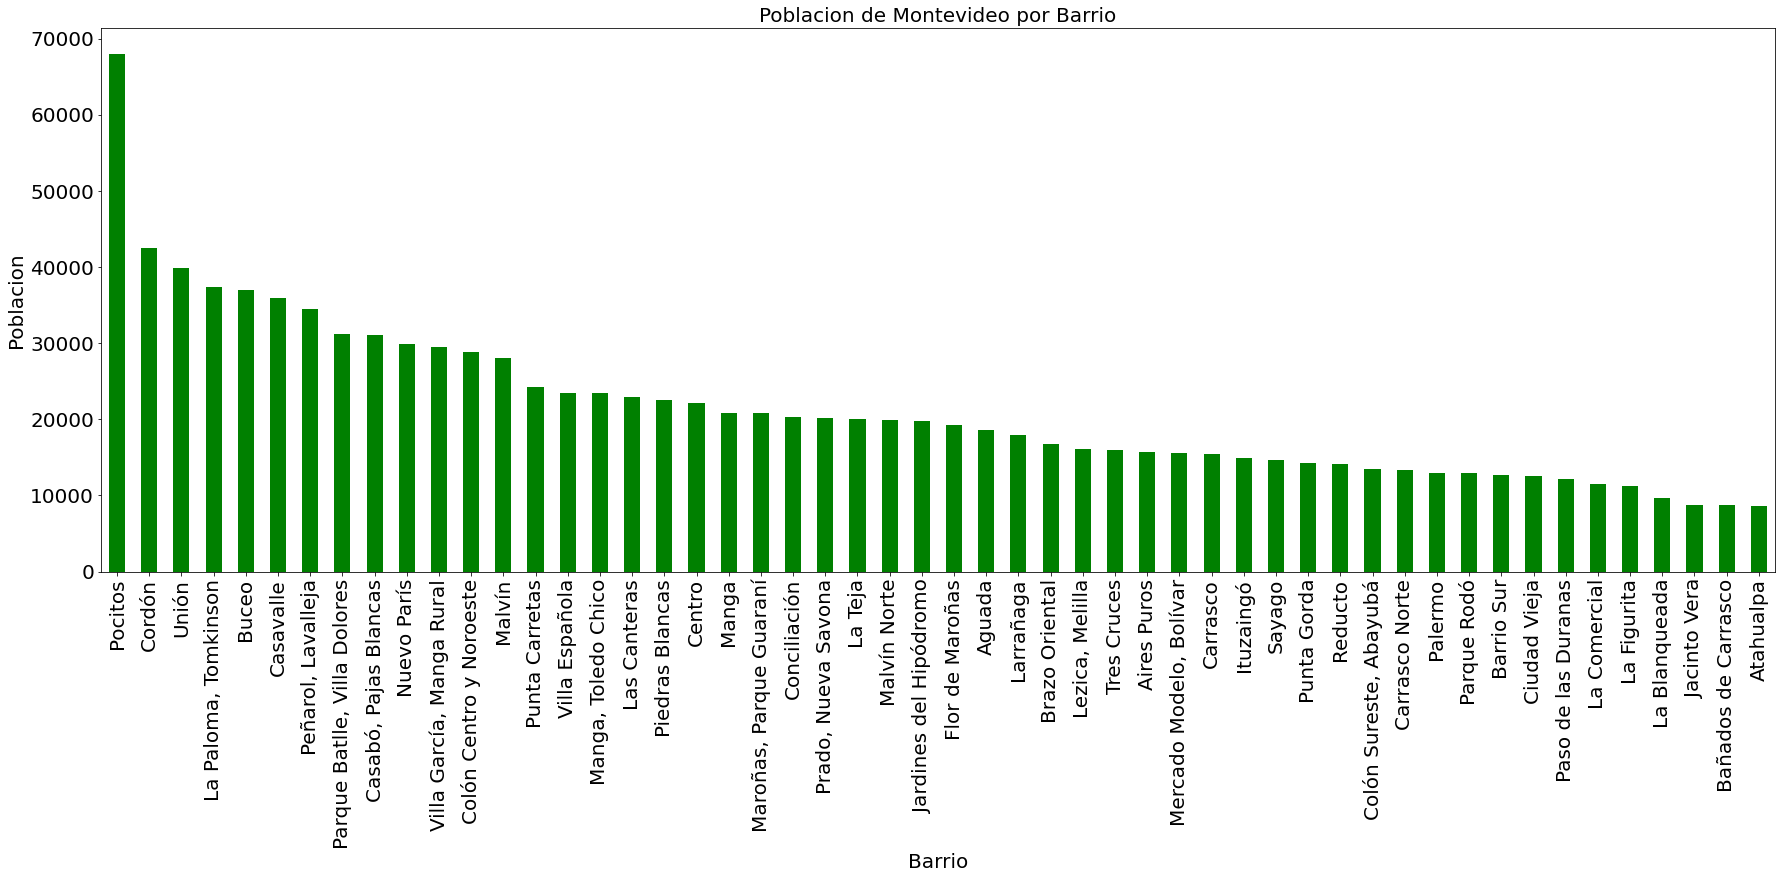

In [28]:
import matplotlib as mpl
import matplotlib.pyplot as plt
df_mv['Poblacion Total'].plot(kind='bar', figsize=(30,10) , color = 'green', fontsize=20)
plt.xlabel('Barrio', fontsize=20)
plt.ylabel('Poblacion', fontsize=20)
plt.title('Poblacion de Montevideo por Barrio',fontsize=20)
plt.show()

Visualizamos la Poblacion total agrupada por municipios en un diagrama de barras

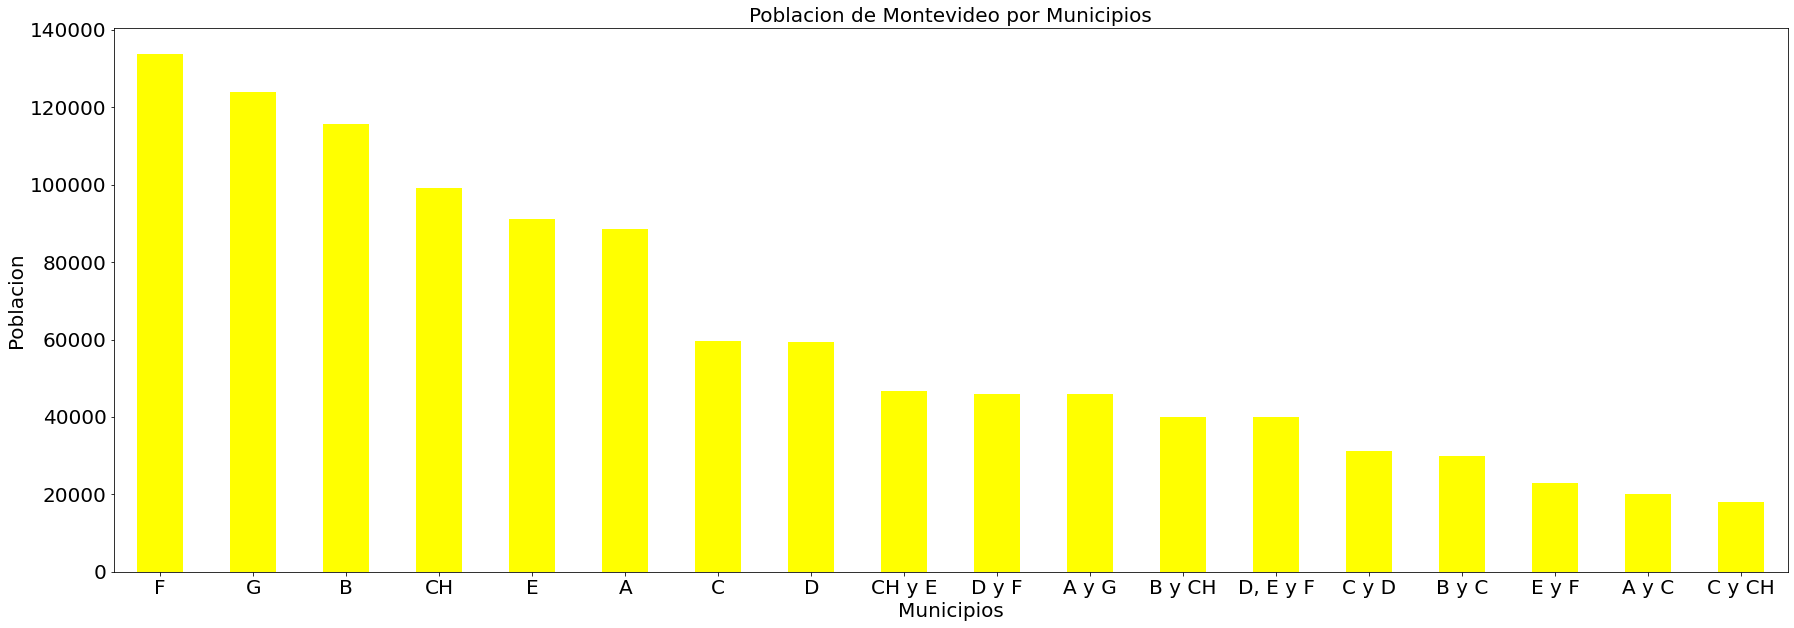

In [29]:
df_mv_muni['Poblacion Total'].plot(kind='bar', figsize=(30,10) , color = 'yellow', fontsize=20)
plt.xlabel('Municipios',fontsize=20)
plt.ylabel('Poblacion',fontsize=20)
plt.title('Poblacion de Montevideo por Municipios',fontsize=20)
plt.xticks(rotation = 0)
plt.show()

Visualizamos el top 5 de Poblacion agrupada por barrios tomando en cuenta tambien la cantidad de hombres y mujeres en un diagrama de barras

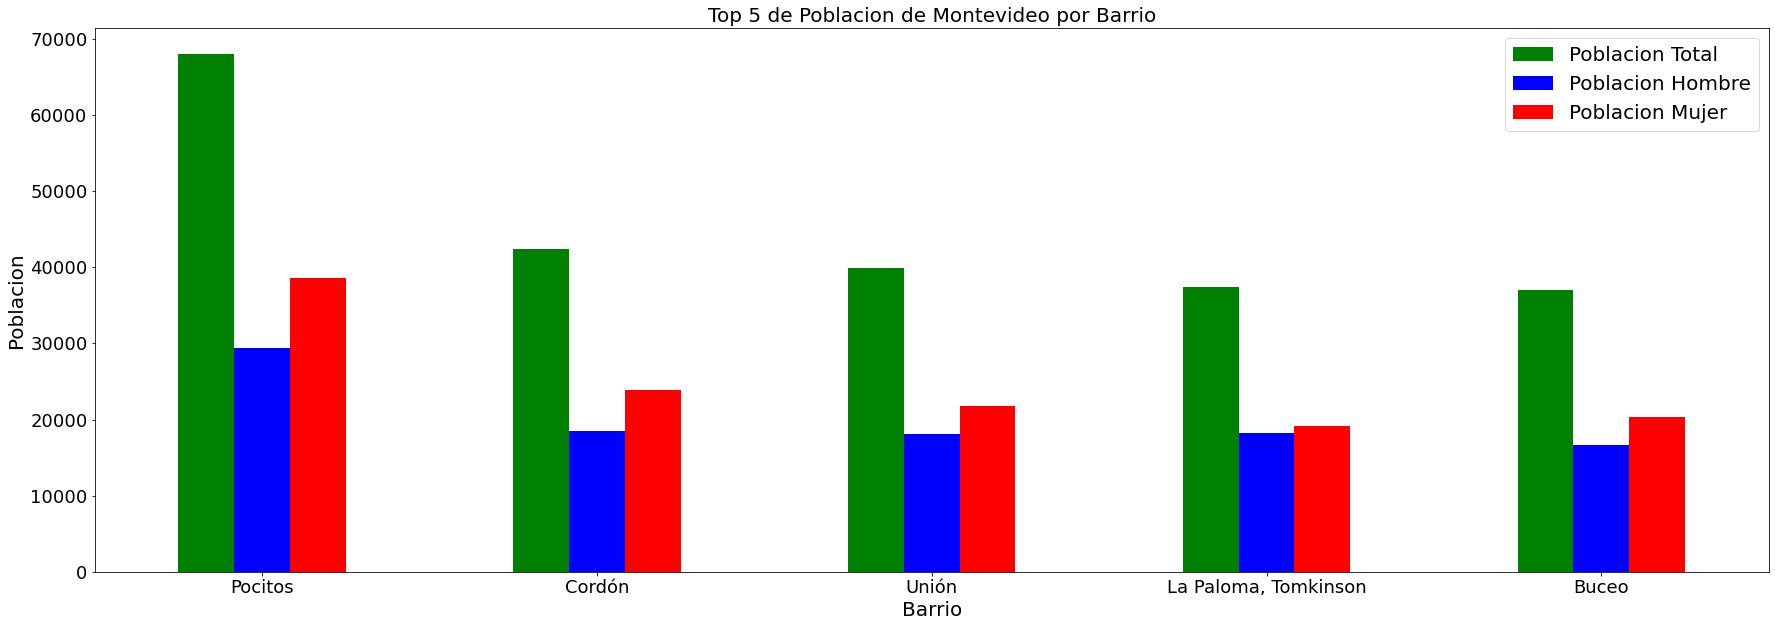

In [30]:
my_colors = ['g','b', 'r']
df_mv.head().plot(kind='bar', figsize=(30,10) , color= my_colors, fontsize=18)
plt.xlabel('Barrio', fontsize=20)
plt.ylabel('Poblacion', fontsize=20)
plt.title('Top 5 de Poblacion de Montevideo por Barrio', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(rotation = 0)
plt.show()

Visualizamos el top 5 de Poblacion agrupada por municipios tomando en cuenta tambien la cantidad de hombres y mujeres en un diagrama de barras

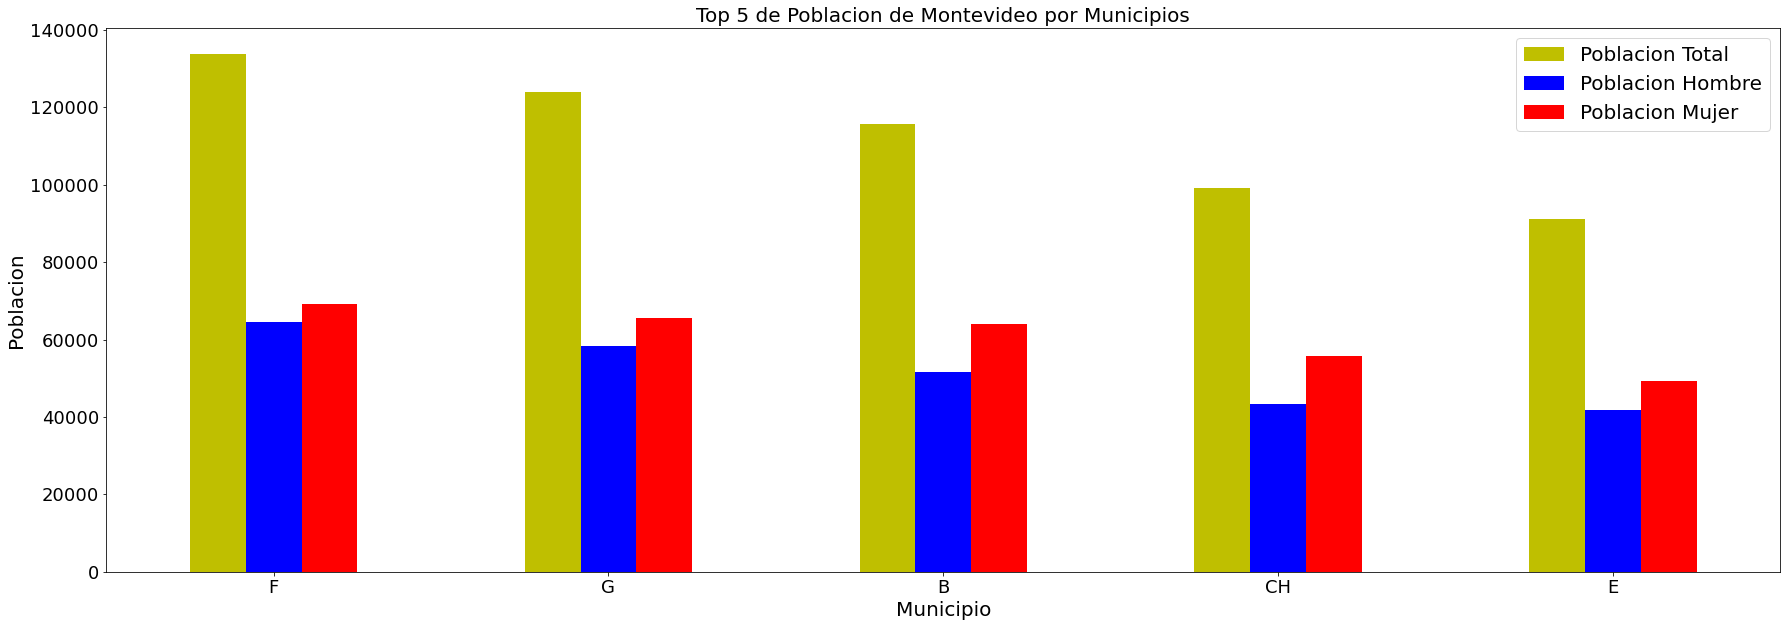

In [31]:
my_colors = ['y','b', 'r']
df_mv_muni.head().plot(kind='bar', figsize=(30,10) , color= my_colors, fontsize=18)
plt.xlabel('Municipio', fontsize=20)
plt.ylabel('Poblacion', fontsize=20)
plt.title('Top 5 de Poblacion de Montevideo por Municipios', fontsize=20)
plt.legend(fontsize=20)
plt.xticks(rotation = 0)
plt.show()

Visualizamos el status socioeconomico por barrios

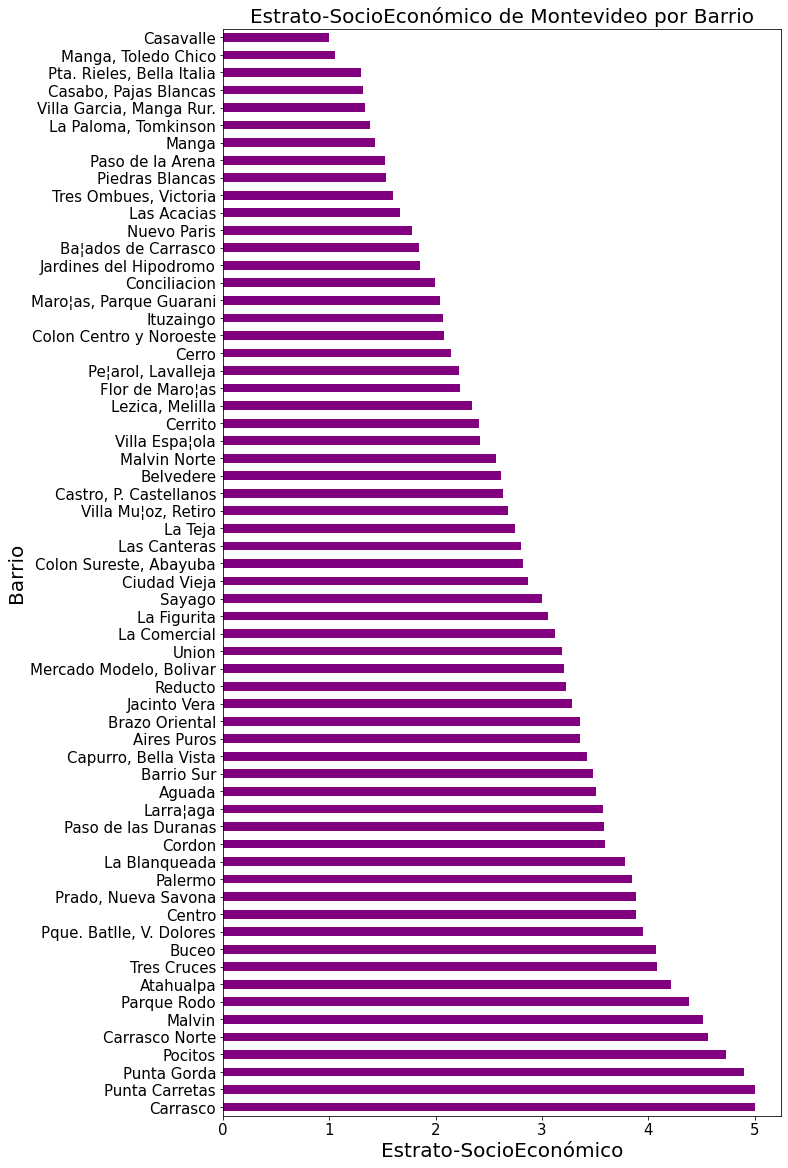

In [32]:
df_mv_eco['Estrato-SocioEconómico'].plot(kind='barh', figsize=(10,20) , color = 'purple', fontsize=15)
plt.xlabel('Estrato-SocioEconómico', fontsize=20)
plt.ylabel('Barrio', fontsize=20)
plt.title('Estrato-SocioEconómico de Montevideo por Barrio',fontsize=20)
plt.show()

Visualizamos el status socioeconomico por municipios 

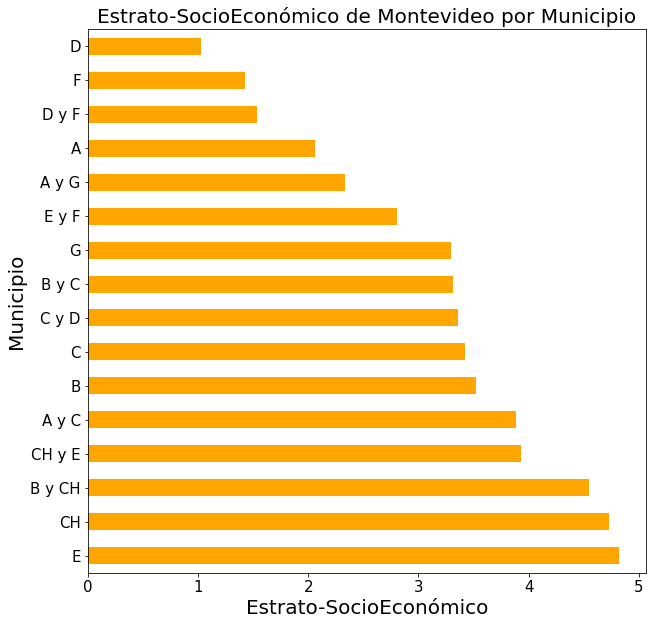

In [33]:
df_mv_eco_muni['Estrato-SocioEconómico'].plot(kind='barh', figsize=(10,10) , color = 'orange', fontsize=15)
plt.xlabel('Estrato-SocioEconómico', fontsize=20)
plt.ylabel('Municipio', fontsize=20)
plt.title('Estrato-SocioEconómico de Montevideo por Municipio',fontsize=20)
plt.show()

Visualizamos el ingreso total del hogar por barrio 

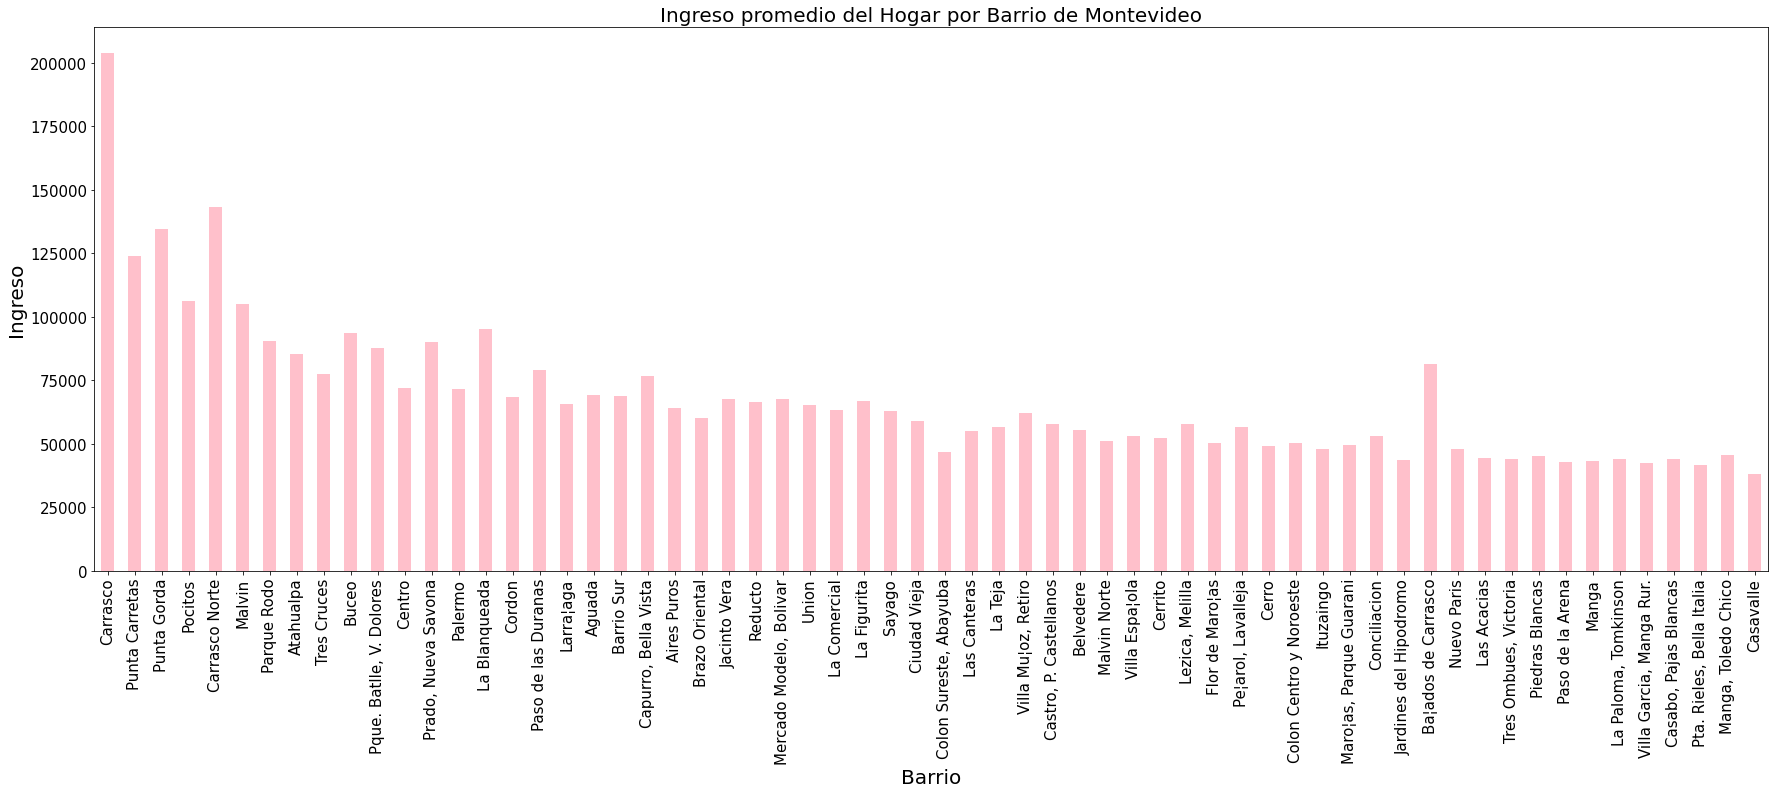

In [34]:
df_mv_eco['Ingreso Total del Hogar'].plot(kind='bar', figsize=(30,10) , color = 'pink', fontsize=15)
plt.xlabel('Barrio', fontsize=20)
plt.ylabel('Ingreso', fontsize=20)
plt.title('Ingreso promedio del Hogar por Barrio de Montevideo',fontsize=20)
plt.show()

Visualizamos el ingreso total del hogar por Municipio 

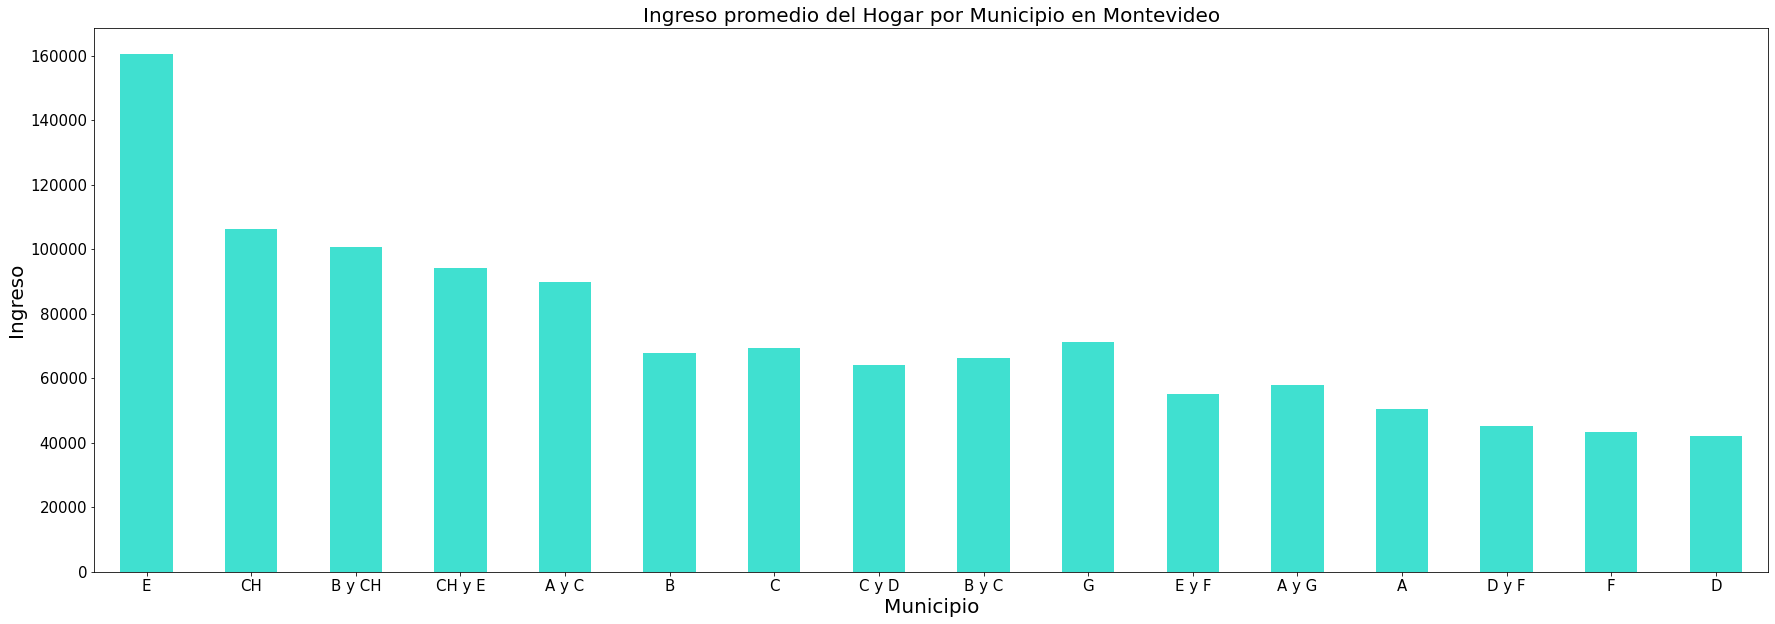

In [35]:
df_mv_eco_muni['Ingreso Total del Hogar'].plot(kind='bar', figsize=(30,10) , color = 'turquoise', fontsize=15)
plt.xlabel('Municipio', fontsize=20)
plt.ylabel('Ingreso', fontsize=20)
plt.title('Ingreso promedio del Hogar por Municipio en Montevideo',fontsize=20)
plt.xticks(rotation = 0)
plt.show()

Visualizamos el top 5 de los barrios con mejor Estrato socioeconomico

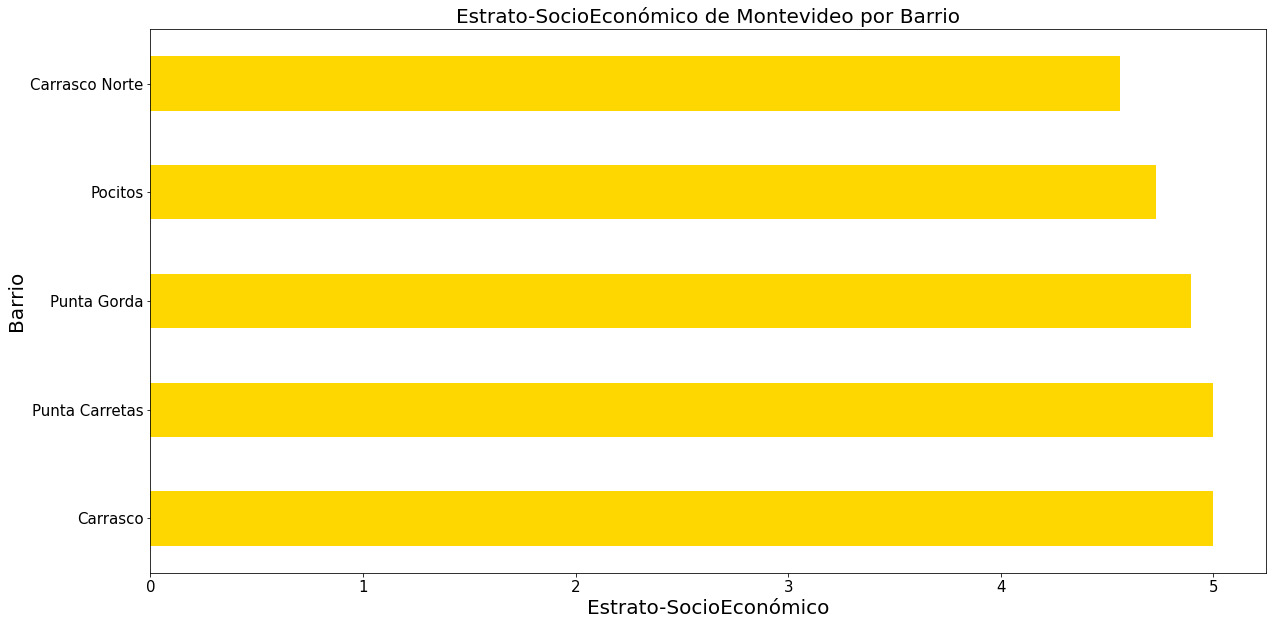

In [36]:
df_mv_eco['Estrato-SocioEconómico'].head().plot(kind='barh', figsize=(20,10) , color = 'gold', fontsize=15)
plt.xlabel('Estrato-SocioEconómico', fontsize=20)
plt.ylabel('Barrio', fontsize=20)
plt.title('Estrato-SocioEconómico de Montevideo por Barrio',fontsize=20)
plt.show()

Visualizamos el top 5 de los municipios con mejor Estrato socioeconomico

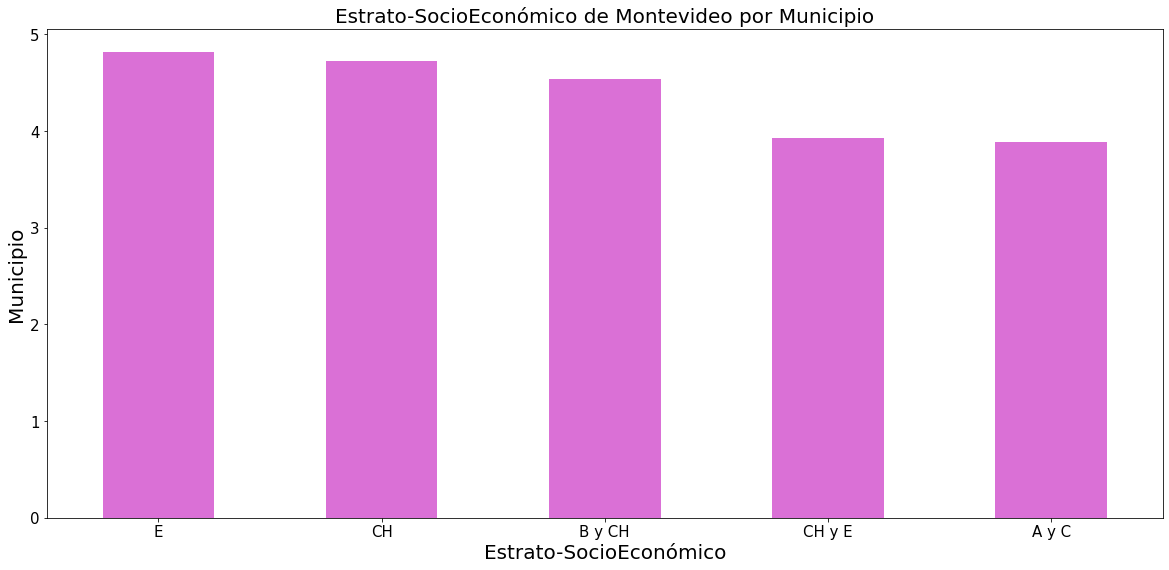

In [37]:
df_mv_eco_muni['Estrato-SocioEconómico'].head().plot(kind='bar', figsize=(20,9) , color = 'orchid', fontsize=15)
plt.xlabel('Estrato-SocioEconómico', fontsize=20)
plt.ylabel('Municipio', fontsize=20)
plt.title('Estrato-SocioEconómico de Montevideo por Municipio',fontsize=20)
plt.xticks(rotation = 0)
plt.show()

Para escoger el lugar la tienda fisica nos centraremos en buscar una ubicacion de tal forma que sea de facil acceso al Top 5 de los barrios con mejor nivel socioeconomico: Carrasco(E), Punta Carretas(B y CH), Punta Gorda (E), Pocitos (CH) y Carrasco Norte (E). Nos centraremos en los municipios E, B y CH y sus uniones

Obtenemos un dataframe que contenga los barrios, longitud y latitud de cada barrio con su respectivos municipios, para luego obtener un nuevo dataframe filtrado que contengan solo los municipios de interes

In [38]:
df_mv_filtrado=pd.merge(df_mv_coord, df_mv_barrios, on='Barrios')
municipios_escogidos=['E','CH','B y CH','CH y E', 'B']
df_mv_filtrado= df_mv_filtrado[df_mv_filtrado.Municipios.isin(municipios_escogidos)]
df_mv_filtrado.reset_index(drop=True)
df_mv_filtrado

,Barrios,Longitud,Latitud,Municipios
0,Ciudad Vieja,-56.205979,-34.906351,B
1,Centro,-56.189656,-34.906067,B
2,Barrio Sur,-56.194784,-34.911202,B
3,Cordón,-56.180125,-34.900827,B
4,Palermo,-56.180698,-34.911288,B
5,Parque Rodó,-56.169778,-34.910082,B
6,Punta Carretas,-56.160065,-34.920202,B y CH
7,Pocitos,-56.150593,-34.911123,CH
8,Buceo,-56.128658,-34.897800,CH y E
9,"Parque Batlle, Villa Dolores",-56.149456,-34.896342,CH


Ahora, aplicaremos la API de Foursquare

In [39]:
CLIENT_ID = '' # su ID de Foursquare
CLIENT_SECRET = '' # Secreto de Foursquare
VERSION = '20180605' # versión de la API de Foursquare
LIMIT = 100 # Un valor límite para la API de Foursquare

print('Your credentails:')

Your credentails:


Seleccionamos el primer barrio del dataframe anterior (Ciudad vieja) para obtener los 100 sitios mas cercanos dentro de n radio de 500 metros

In [40]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
CV_latitud= -34.906351
CV_longitud=-56.205979
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    CV_latitud, 
    CV_longitud, 
    radius, 
    LIMIT)

In [41]:
# Enviar la solicitud GET y examinar los resultados.
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '627306e7f00d5025640c4c9d'},
 'response': {'queryRefinements': {'target': {'type': 'path',
    'url': '/venue/explore',
    'params': {'ll': '-34.906351,-56.205979', 'radius': '500'}},
   'refinements': [{'query': 'Food'},
    {'query': 'Nightlife'},
    {'query': 'Coffee'},
    {'query': 'Shops'},
    {'query': 'Arts'},
    {'query': 'Outdoors'}]},
  'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Ciudad Vieja',
  'headerFullLocation': 'Ciudad Vieja, Montevideo',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 66,
  'suggestedBounds': {'ne': {'lat': -34.9018509955, 'lng': -56.200502026788},
   'sw': {'lat': -34.9108510045, 'lng': -56.211455973212}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName

De los laboratorios del cuurso, se sabe que toda la información esta en la llave items y antes de avanzar, usaremos la función get_category_type de los laboratorios anteriores.

In [42]:
# función para extraer la categoria del sitio
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# Ahora estamos listos para limpiar el objeto json y estructurarlo en un dataframe pandas
venues = results['response']['groups'][0]['items']
nearby_venues = json_normalize(venues) # objeto JSON

# filtrar columnas
filtered_columns = ['venue.name', 'venue.location.address' , 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filtrar la categoría para cada fila
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# limpiar columnas
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()

# ¿Cuantos sitios nos regresó FourSquare?
print('{} venues fueron devueltos por Foursquare.'.format(nearby_venues.shape[0]))

66 venues fueron devueltos por Foursquare.


/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  from ipykernel import kernelapp as app


In [43]:
nearby_venues.head()

,name,address,categories,lat,lng
0,Estrecho,Sarandí 460,South American Restaurant,-34.907824,-56.205743
1,Plaza Matriz,Sarandí,Plaza,-34.906615,-56.203541
2,Café Brasilero,Ituzaingó 1447,Café,-34.905741,-56.204651
3,Plaza Zabala,Circunvalación Durango,Plaza,-34.907561,-56.208117
4,Che.co.ffe,Zabala 1341,Coffee Shop,-34.908427,-56.206793


Vamos a crear una función que repita el mismo proceso para todos los barrios de los municipios escogidos

In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # crear la URL de solicitud de API
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # solicitud GET
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # regresa solo información relevante de cada sitio cercano
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['location']['formattedAddress'][0],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Barrio', 
                  'Barrio_Latitud', 
                  'Barrio_Longitud', 
                  'Lugar',
                  'Lugar_Latitud', 
                  'Lugar_Longitud',
                  'Dirección',          
                  'Categoria']
    
    return(nearby_venues)

Ahora desarrollamos el código para determinar los sitios por barrio de los municipios B,CH y E, y creamos un dataframe df_montevideo_bche_sitios.

In [45]:
df_mv_venues = getNearbyVenues(names=df_mv_filtrado['Barrios'],
                                   latitudes=df_mv_filtrado['Latitud'],
                                   longitudes=df_mv_filtrado['Longitud']
                                  )

Ciudad Vieja
Centro
Barrio Sur
Cordón
Palermo
Parque Rodó
Punta Carretas
Pocitos
Buceo
Parque Batlle, Villa Dolores
Malvín
Malvín Norte
Punta Gorda
Carrasco
Carrasco Norte
La Blanqueada
Tres Cruces


In [46]:
print(df_mv_venues.shape)
df_mv_venues.head()

(552, 8)


,Barrio,Barrio_Latitud,Barrio_Longitud,Lugar,Lugar_Latitud,Lugar_Longitud,Dirección,Categoria
0,Ciudad Vieja,-34.906351,-56.205979,Estrecho,-34.907824,-56.205743,Sarandí 460 (e/ Misiones y Treinta y Tres),South American Restaurant
1,Ciudad Vieja,-34.906351,-56.205979,Plaza Matriz,-34.906615,-56.203541,Sarandí (Juan Carlos Gómez),Plaza
2,Ciudad Vieja,-34.906351,-56.205979,Café Brasilero,-34.905741,-56.204651,Ituzaingó 1447 (e/ 25 de Mayo y Rincón),Café
3,Ciudad Vieja,-34.906351,-56.205979,Plaza Zabala,-34.907561,-56.208117,Circunvalación Durango,Plaza
4,Ciudad Vieja,-34.906351,-56.205979,Che.co.ffe,-34.908427,-56.206793,Zabala 1341 (Sarandi),Coffee Shop


Revisemos cuantos sitios se regresarón para cada barrio Encontremos cuantas categorías únicas se pueden conservar de todos los sitios regresados

In [47]:
print('Sitios por Barrio',df_mv_venues.groupby('Barrio')['Lugar'].count())
print('Hay {} categorias únicas.'.format(len(df_mv_venues['Categoria'].unique())))

Sitios por Barrio Barrio
Barrio Sur                      38
Buceo                            4
Carrasco                        39
Carrasco Norte                   4
Centro                          63
Ciudad Vieja                    66
Cordón                          35
La Blanqueada                    9
Malvín                           7
Malvín Norte                     4
Palermo                         31
Parque Batlle, Villa Dolores    16
Parque Rodó                     60
Pocitos                         62
Punta Carretas                  86
Punta Gorda                      6
Tres Cruces                     22
Name: Lugar, dtype: int64
Hay 132 categorias únicas.


In [48]:
df_mv_venues['Categoria'].unique()

array(['South American Restaurant', 'Plaza', 'Café', 'Coffee Shop',
       'Comfort Food Restaurant', 'Hostel', 'History Museum',
       'Art Gallery', 'Hotel', 'Health Food Store', 'Salad Place',
       'Pedestrian Plaza', 'Art Museum', 'Ice Cream Shop', 'Restaurant',
       'Dessert Shop', 'Latin American Restaurant',
       'Vegetarian / Vegan Restaurant', 'Tapas Restaurant', 'Juice Bar',
       'Swiss Restaurant', 'Public Art', 'Design Studio', 'Theater',
       'Opera House', 'BBQ Joint', 'Furniture / Home Store', 'Bookstore',
       'Monument / Landmark', 'Bistro', 'Southern / Soul Food Restaurant',
       'Breakfast Spot', 'Pizza Place', 'Scenic Lookout', 'Deli / Bodega',
       'Government Building', 'Food & Drink Shop', 'Bar',
       'Chocolate Shop', 'Irish Pub', 'Italian Restaurant',
       'Sushi Restaurant', 'Bakery', 'Nightclub', 'Science Museum',
       'Bus Station', 'Kebab Restaurant', 'Convenience Store',
       'Spanish Restaurant', 'Clothing Store', 'Fountain',
    

Nos centramos en los lugares de interes como spa, salones de belleza, tiendas de cosmeticos, lugares para mujeres, comida saludable, sitios al aire libre y verdes como parques y plazas.

In [49]:
lugares_interes=['Plaza', 'Health Food Store', 'Vegetarian / Vegan Restaurant','Supermarket', 'Smoothie Shop','Flea Market', "Women's Store",'Night Market','Market', 'Park','Grocery Store','Gourmet Shop','Restaurant','Food']

df_mv_venues_1 = df_mv_venues[df_mv_venues['Categoria'].str.contains('Restaurant', 'Food')]
df_mv_venues_2= df_mv_venues[df_mv_venues.Categoria.isin(lugares_interes)]
df_mv_venues_3 = df_mv_venues[df_mv_venues['Lugar'].str.contains('Beauty', 'Spa')]
df_mv_venues_4 = pd.concat([df_mv_venues_1, df_mv_venues_2, df_mv_venues_3])
df_mv_venues_4.drop_duplicates(['Lugar'], inplace = True)
df_mv_venues_4

,Barrio,Barrio_Latitud,Barrio_Longitud,Lugar,Lugar_Latitud,Lugar_Longitud,Dirección,Categoria
0,Ciudad Vieja,-34.906351,-56.205979,Estrecho,-34.907824,-56.205743,Sarandí 460 (e/ Misiones y Treinta y Tres),South American Restaurant
5,Ciudad Vieja,-34.906351,-56.205979,Sin Pretensiones,-34.908424,-56.207495,Sarandi 366 (Alzaibar),Comfort Food Restaurant
17,Ciudad Vieja,-34.906351,-56.205979,Jacinto,-34.908516,-56.207826,Sarandí 349 (Alzaibar),Restaurant
19,Ciudad Vieja,-34.906351,-56.205979,Úrbani Plaza Zabala,-34.907486,-56.207924,Circunvalación Durango 381 (Primero de Mayo),Latin American Restaurant
20,Ciudad Vieja,-34.906351,-56.205979,Sámsara,-34.908804,-56.206497,Zabala 1316 (e/ Sarandí y Buenos Aires),Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...,...
519,Carrasco Norte,-34.872898,-56.072086,Canchita Carrasco Norte,-34.873503,-56.070818,Agustin Musso (Calle D-Habre-F.Gomez Marin),Park
520,Carrasco Norte,-34.872898,-56.072086,Multiahorro,-34.870531,-56.069228,Cooper (Cno. Carrasco),Grocery Store
531,Tres Cruces,-34.892518,-56.167113,Congelados Glacial,-34.889187,-56.166830,Duvimioso Terra 2050 (Hocquart),Grocery Store
537,Tres Cruces,-34.892518,-56.167113,Plaza de la Bandera,-34.893570,-56.164416,Bvar. Artigas (Av. Italia),Plaza


In [50]:
df_mv_venues_4.reset_index(drop=True, inplace=True)
df_mv_venues_4

,Barrio,Barrio_Latitud,Barrio_Longitud,Lugar,Lugar_Latitud,Lugar_Longitud,Dirección,Categoria
0,Ciudad Vieja,-34.906351,-56.205979,Estrecho,-34.907824,-56.205743,Sarandí 460 (e/ Misiones y Treinta y Tres),South American Restaurant
1,Ciudad Vieja,-34.906351,-56.205979,Sin Pretensiones,-34.908424,-56.207495,Sarandi 366 (Alzaibar),Comfort Food Restaurant
2,Ciudad Vieja,-34.906351,-56.205979,Jacinto,-34.908516,-56.207826,Sarandí 349 (Alzaibar),Restaurant
3,Ciudad Vieja,-34.906351,-56.205979,Úrbani Plaza Zabala,-34.907486,-56.207924,Circunvalación Durango 381 (Primero de Mayo),Latin American Restaurant
4,Ciudad Vieja,-34.906351,-56.205979,Sámsara,-34.908804,-56.206497,Zabala 1316 (e/ Sarandí y Buenos Aires),Vegetarian / Vegan Restaurant
...,...,...,...,...,...,...,...,...
121,Carrasco Norte,-34.872898,-56.072086,Canchita Carrasco Norte,-34.873503,-56.070818,Agustin Musso (Calle D-Habre-F.Gomez Marin),Park
122,Carrasco Norte,-34.872898,-56.072086,Multiahorro,-34.870531,-56.069228,Cooper (Cno. Carrasco),Grocery Store
123,Tres Cruces,-34.892518,-56.167113,Congelados Glacial,-34.889187,-56.166830,Duvimioso Terra 2050 (Hocquart),Grocery Store
124,Tres Cruces,-34.892518,-56.167113,Plaza de la Bandera,-34.893570,-56.164416,Bvar. Artigas (Av. Italia),Plaza


Analizamos cada barrio

In [51]:
# codificación
df_mv_venues_onehot = pd.get_dummies(df_mv_venues_4[['Categoria']], prefix="", prefix_sep="")

# añadir la columna de barrio de regreso al dataframe
df_mv_venues_onehot['Barrio'] = df_mv_venues_4['Barrio'] 

# mover la columna de barrio a la primer columna
fixed_columns = [df_mv_venues_onehot.columns[-1]] + list(df_mv_venues_onehot.columns[:-1])
df_mv_venues_onehot = df_mv_venues_onehot[fixed_columns]

df_mv_venues_onehot.head()

,Barrio,American Restaurant,Chinese Restaurant,Comfort Food Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food,German Restaurant,...,Smoothie Shop,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Women's Store
0,Ciudad Vieja,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,Ciudad Vieja,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ciudad Vieja,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Ciudad Vieja,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ciudad Vieja,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Examinemos el tamaño del nuevo dataframe

In [52]:
df_mv_venues_onehot.shape

(126, 38)

Agrupemos las filas por barrios tomando la média de la frecuancia de la ocurrencia de cada categoría

In [53]:
df_mv_venues_grouped = df_mv_venues_onehot.groupby('Barrio').mean().reset_index()
df_mv_venues_grouped

,Barrio,American Restaurant,Chinese Restaurant,Comfort Food Restaurant,Empanada Restaurant,Falafel Restaurant,Fast Food Restaurant,Flea Market,Food,German Restaurant,...,Smoothie Shop,South American Restaurant,Southern / Soul Food Restaurant,Spanish Restaurant,Supermarket,Sushi Restaurant,Swiss Restaurant,Tapas Restaurant,Vegetarian / Vegan Restaurant,Women's Store
0,Barrio Sur,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000
1,Buceo,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Carrasco,0.142857,0.071429,0.071429,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Carrasco Norte,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,Centro,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.083333,0.083333,0.000000,0.000000,0.000000,0.000000,0.000000
5,Ciudad Vieja,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.052632,0.052632,0.000000,0.000000,0.052632,0.052632,0.052632,0.052632,0.000000
6,Cordón,0.000000,0.000000,0.000000,0.000000,0.000000,0.166667,0.166667,0.000000,0.000000,...,0.00,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,La Blanqueada,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,Malvín,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,Malvín Norte,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.00,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Confirmemos el nuevo tamaño

In [54]:
df_mv_venues_grouped.shape

(16, 38)

Imprimamos cada barrio junto con los 5 sitios mas comunes

In [55]:
num_top_venues = 5

for barrio in df_mv_venues_grouped['Barrio']:
    print("----"+barrio+"----")
    temp = df_mv_venues_grouped[df_mv_venues_grouped['Barrio'] == barrio].T.reset_index()
    temp.columns = ['sitio','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Barrio Sur----
                           sitio  freq
0            American Restaurant  0.25
1                  Smoothie Shop  0.25
2  Vegetarian / Vegan Restaurant  0.25
3                     Restaurant  0.25
4     Modern European Restaurant  0.00


----Buceo----
                        sitio  freq
0               Grocery Store   1.0
1         American Restaurant   0.0
2  Modern European Restaurant   0.0
3                Night Market   0.0
4                        Park   0.0


----Carrasco----
                     sitio  freq
0               Restaurant  0.29
1      American Restaurant  0.14
2                    Plaza  0.14
3  Comfort Food Restaurant  0.07
4                     Park  0.07


----Carrasco Norte----
                        sitio  freq
0               Grocery Store   0.5
1                        Park   0.5
2         American Restaurant   0.0
3  Modern European Restaurant   0.0
4                Night Market   0.0


----Centro----
                       sitio  freq
0    

Pongamos eso en el dataframe

Primero escribamos una función para ordenar los sitios en orden descendente.

In [56]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Generemos el nuevo dataframe y mostremos los primeros 10 sitios de cada barrio.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# crear las columnas acorde al numero de sitios populares
columns = ['Barrio']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# crear un nuevo dataframe
df_mv_venues_sorted = pd.DataFrame(columns=columns)
df_mv_venues_sorted['Barrio'] = df_mv_venues_grouped['Barrio']

for ind in np.arange(df_mv_venues_grouped.shape[0]):
    df_mv_venues_sorted.iloc[ind, 1:] = return_most_common_venues(df_mv_venues_grouped.iloc[ind, :], num_top_venues)

df_mv_venues_sorted.head()

,Barrio,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Barrio Sur,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
1,Buceo,Grocery Store,American Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant
2,Carrasco,Restaurant,American Restaurant,Plaza,Comfort Food Restaurant,Park,Chinese Restaurant,Market,German Restaurant,Gourmet Shop,South American Restaurant
3,Carrasco Norte,Grocery Store,Park,American Restaurant,Modern European Restaurant,Night Market,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant
4,Centro,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant


## Barrios Agrupados

Ejecutemos k-means para agrupar los barrios en 5 agrupaciones

In [58]:
# importar k-means desde la fase de agrupación
from sklearn.cluster import KMeans

# establecer el número de agrupaciones
kclusters = 5

df_mv_grouped_clustering = df_mv_venues_grouped.drop('Barrio', 1)

# ejecutar k-means
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df_mv_grouped_clustering)

# revisar las etiquetas de las agrupaciones generadas para cada fila del dataframe
kmeans.labels_[0:10] 

/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/utils/validation.py:37: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  LARGE_SPARSE_SUPPORTED = LooseVersion(scipy_version) >= '0.14.0'
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/jupyterlab/conda/envs/python/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing th

array([0, 1, 0, 1, 0, 0, 0, 2, 0, 3], dtype=int32)

Generemos un nuevo dataframe que incluya la agrupación asi como los 10 sitios mas populares de cada barrio.

In [59]:
# añadir etiquetas
df_mv_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

mv_barrios_merged = df_mv_filtrado

# juntar manhattan_grouped con manhattan_data 
mv_barrios_merged = mv_barrios_merged.join(df_mv_venues_sorted.set_index('Barrio'), on='Barrios')

mv_barrios_merged.head() # revisar las ultimas columnas

,Barrios,Longitud,Latitud,Municipios,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciudad Vieja,-56.205979,-34.906351,B,0.0,Restaurant,Plaza,South American Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Swiss Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant
1,Centro,-56.189656,-34.906067,B,0.0,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant
2,Barrio Sur,-56.194784,-34.911202,B,0.0,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
3,Cordón,-56.180125,-34.900827,B,0.0,South American Restaurant,Plaza,Fast Food Restaurant,Flea Market,Restaurant,American Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
4,Palermo,-56.180698,-34.911288,B,0.0,Restaurant,South American Restaurant,Flea Market,Italian Restaurant,American Restaurant,Night Market,Park,Plaza,Seafood Restaurant,Smoothie Shop


In [60]:
mv_barrios_merged = df_mv_filtrado

# juntar manhattan_grouped con manhattan_data 
mv_barrios_merged = mv_barrios_merged.join(df_mv_venues_sorted.set_index('Barrio'), on='Barrios')

mv_barrios_merged.head() # revisar las ultimas columnas

,Barrios,Longitud,Latitud,Municipios,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciudad Vieja,-56.205979,-34.906351,B,0.0,Restaurant,Plaza,South American Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Swiss Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant
1,Centro,-56.189656,-34.906067,B,0.0,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant
2,Barrio Sur,-56.194784,-34.911202,B,0.0,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
3,Cordón,-56.180125,-34.900827,B,0.0,South American Restaurant,Plaza,Fast Food Restaurant,Flea Market,Restaurant,American Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
4,Palermo,-56.180698,-34.911288,B,0.0,Restaurant,South American Restaurant,Flea Market,Italian Restaurant,American Restaurant,Night Market,Park,Plaza,Seafood Restaurant,Smoothie Shop


In [61]:
mv_barrios_merged

,Barrios,Longitud,Latitud,Municipios,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciudad Vieja,-56.205979,-34.906351,B,0.0,Restaurant,Plaza,South American Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Swiss Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant
1,Centro,-56.189656,-34.906067,B,0.0,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant
2,Barrio Sur,-56.194784,-34.911202,B,0.0,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
3,Cordón,-56.180125,-34.900827,B,0.0,South American Restaurant,Plaza,Fast Food Restaurant,Flea Market,Restaurant,American Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
4,Palermo,-56.180698,-34.911288,B,0.0,Restaurant,South American Restaurant,Flea Market,Italian Restaurant,American Restaurant,Night Market,Park,Plaza,Seafood Restaurant,Smoothie Shop
5,Parque Rodó,-56.169778,-34.910082,B,0.0,Restaurant,American Restaurant,Flea Market,Italian Restaurant,Supermarket,Food,Grocery Store,Tapas Restaurant,Empanada Restaurant,Swiss Restaurant
6,Punta Carretas,-56.160065,-34.920202,B y CH,0.0,Restaurant,Mediterranean Restaurant,Italian Restaurant,Women's Store,Night Market,Flea Market,Modern European Restaurant,Fast Food Restaurant,Mexican Restaurant,Sushi Restaurant
7,Pocitos,-56.150593,-34.911123,CH,0.0,Italian Restaurant,Supermarket,South American Restaurant,Restaurant,Empanada Restaurant,Falafel Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,Market
8,Buceo,-56.128658,-34.897800,CH y E,1.0,Grocery Store,American Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant
9,"Parque Batlle, Villa Dolores",-56.149456,-34.896342,CH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
mv_barrios_merged.drop(9, axis=0, inplace = True)
mv_barrios_merged.reset_index(drop=True, inplace = True)
mv_barrios_merged

,Barrios,Longitud,Latitud,Municipios,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciudad Vieja,-56.205979,-34.906351,B,0.0,Restaurant,Plaza,South American Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Swiss Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant
1,Centro,-56.189656,-34.906067,B,0.0,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant
2,Barrio Sur,-56.194784,-34.911202,B,0.0,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
3,Cordón,-56.180125,-34.900827,B,0.0,South American Restaurant,Plaza,Fast Food Restaurant,Flea Market,Restaurant,American Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
4,Palermo,-56.180698,-34.911288,B,0.0,Restaurant,South American Restaurant,Flea Market,Italian Restaurant,American Restaurant,Night Market,Park,Plaza,Seafood Restaurant,Smoothie Shop
5,Parque Rodó,-56.169778,-34.910082,B,0.0,Restaurant,American Restaurant,Flea Market,Italian Restaurant,Supermarket,Food,Grocery Store,Tapas Restaurant,Empanada Restaurant,Swiss Restaurant
6,Punta Carretas,-56.160065,-34.920202,B y CH,0.0,Restaurant,Mediterranean Restaurant,Italian Restaurant,Women's Store,Night Market,Flea Market,Modern European Restaurant,Fast Food Restaurant,Mexican Restaurant,Sushi Restaurant
7,Pocitos,-56.150593,-34.911123,CH,0.0,Italian Restaurant,Supermarket,South American Restaurant,Restaurant,Empanada Restaurant,Falafel Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,Market
8,Buceo,-56.128658,-34.897800,CH y E,1.0,Grocery Store,American Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant
9,Malvín,-56.094768,-34.889692,E,0.0,Park,Restaurant,American Restaurant,Mexican Restaurant,Modern European Restaurant,Night Market,Plaza,Seafood Restaurant,Smoothie Shop,South American Restaurant


In [63]:
mv_barrios_merged['Cluster Labels'] = mv_barrios_merged['Cluster Labels'].astype(int)

Finalmente visualicemos las agrupaciones resultantes

In [64]:
# crear mapa
import matplotlib.cm as cm
import matplotlib.colors as colors
map_mv_clusters = folium.Map(location=[latitude_mv, longitude_mv], zoom_start=11)

# establecer el esquema de color para las agrupaciones
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# añadir marcadores al mapa
markers_colors = []
for lat, lon, poi, cluster in zip(mv_barrios_merged['Latitud'], mv_barrios_merged['Longitud'],
                                  mv_barrios_merged['Barrios'], mv_barrios_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_mv_clusters)
       
map_mv_clusters

Ahora se puede examinar cada agrupación y determinar las categorias del sitio que distingue a cada agrupación.

In [65]:
mv_barrios_merged.loc[mv_barrios_merged['Cluster Labels'] == 0, mv_barrios_merged.columns[[0] + list(range(5, mv_barrios_merged.shape[1]))]]

,Barrios,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ciudad Vieja,Restaurant,Plaza,South American Restaurant,Comfort Food Restaurant,Vegetarian / Vegan Restaurant,Tapas Restaurant,Swiss Restaurant,Sushi Restaurant,Southern / Soul Food Restaurant,Latin American Restaurant
1,Centro,Restaurant,Plaza,Chinese Restaurant,Market,Latin American Restaurant,Supermarket,Spanish Restaurant,Kebab Restaurant,Italian Restaurant,American Restaurant
2,Barrio Sur,American Restaurant,Smoothie Shop,Vegetarian / Vegan Restaurant,Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Seafood Restaurant,South American Restaurant
3,Cordón,South American Restaurant,Plaza,Fast Food Restaurant,Flea Market,Restaurant,American Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
4,Palermo,Restaurant,South American Restaurant,Flea Market,Italian Restaurant,American Restaurant,Night Market,Park,Plaza,Seafood Restaurant,Smoothie Shop
5,Parque Rodó,Restaurant,American Restaurant,Flea Market,Italian Restaurant,Supermarket,Food,Grocery Store,Tapas Restaurant,Empanada Restaurant,Swiss Restaurant
6,Punta Carretas,Restaurant,Mediterranean Restaurant,Italian Restaurant,Women's Store,Night Market,Flea Market,Modern European Restaurant,Fast Food Restaurant,Mexican Restaurant,Sushi Restaurant
7,Pocitos,Italian Restaurant,Supermarket,South American Restaurant,Restaurant,Empanada Restaurant,Falafel Restaurant,Middle Eastern Restaurant,Mexican Restaurant,Chinese Restaurant,Market
9,Malvín,Park,Restaurant,American Restaurant,Mexican Restaurant,Modern European Restaurant,Night Market,Plaza,Seafood Restaurant,Smoothie Shop,South American Restaurant
12,Carrasco,Restaurant,American Restaurant,Plaza,Comfort Food Restaurant,Park,Chinese Restaurant,Market,German Restaurant,Gourmet Shop,South American Restaurant


In [66]:
mv_barrios_merged.loc[mv_barrios_merged['Cluster Labels'] == 1, mv_barrios_merged.columns[[0] + list(range(5, mv_barrios_merged.shape[1]))]]

,Barrios,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Buceo,Grocery Store,American Restaurant,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant
13,Carrasco Norte,Grocery Store,Park,American Restaurant,Modern European Restaurant,Night Market,Plaza,Restaurant,Seafood Restaurant,Smoothie Shop,South American Restaurant


In [67]:
mv_barrios_merged.loc[mv_barrios_merged['Cluster Labels'] == 2, mv_barrios_merged.columns[[0] + list(range(5, mv_barrios_merged.shape[1]))]]

,Barrios,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,La Blanqueada,Latin American Restaurant,American Restaurant,Smoothie Shop,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,South American Restaurant


In [68]:
mv_barrios_merged.loc[mv_barrios_merged['Cluster Labels'] == 3, mv_barrios_merged.columns[[0] + list(range(5, mv_barrios_merged.shape[1]))]]

,Barrios,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Malvín Norte,Supermarket,American Restaurant,Smoothie Shop,Modern European Restaurant,Night Market,Park,Plaza,Restaurant,Seafood Restaurant,South American Restaurant


In [69]:
mv_barrios_merged.loc[mv_barrios_merged['Cluster Labels'] == 4, mv_barrios_merged.columns[[0] + list(range(5, mv_barrios_merged.shape[1]))]]

,Barrios,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
11,Punta Gorda,Plaza,Latin American Restaurant,Seafood Restaurant,American Restaurant,Smoothie Shop,Modern European Restaurant,Night Market,Park,Restaurant,South American Restaurant
15,Tres Cruces,Latin American Restaurant,Grocery Store,Chinese Restaurant,Plaza,Restaurant,Middle Eastern Restaurant,Night Market,Park,Seafood Restaurant,Smoothie Shop
